# Module: braggdiskdetection

This module contains functions finding the positions of the Bragg disks in a 4DSTEM scan.  Generally this will involve two steps: getting a vacuum probe, then finding the Bragg disks using the vacuum probe as a template. 

## Submodule: probetemplate

The notebook demos functions related to getting a vacuum probe.  Ultimately, the purpose is to generate a kernel for convolution with individual diffraction patterns to identify Bragg disks.  Kernel generation will generally proceed in two steps, each of which will correspond to a function call: obtaining or creating the diffraction pattern of an average probe in vacuum, then turning the probe DP into a convolution kernel.

The demos below include functions for:
* Getting the average vacuum probe
* Getting the probe kernel from a vacuum probe
* Automated determination of parameters for synthetic probes

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_vacuum_scan
from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI
from py4DSTEM.process.braggdiskdetection import get_synthetic_probe

from py4DSTEM.process.braggdiskdetection import get_probe_kernel
from py4DSTEM.process.braggdiskdetection import get_probe_kernel_subtrgaussian
from py4DSTEM.process.braggdiskdetection import get_probe_kernel_logistictrench

### Get the average vacuum probe

The following approaches are demoed below:
1. From a vacuum 4DSTEM scan
2. From a selected ROI of a 4DSTEM scan
3. Synthetic probe

#### From a vacuum scan

In [2]:
# Load data

fp = "/home/ben/Data/20181205_LCOLIPON_NovFIB/h5/Stack 1_VacuumProbe_10x10_ss30nm_0p01s_spot 11_alpha=0p48_bin2_cl130_300kV.h5"
dc = py4DSTEM.readwrite.read(fp)

/home/ben/Data/20181205_LCOLIPON_NovFIB/h5/Stack 1_VacuumProbe_10x10_ss30nm_0p01s_spot 11_alpha=0p48_bin2_cl130_300kV.h5 is a py4DSTEM file, v0.2. Reading...


In [3]:
# Get probe

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3
verbose = False

probe = get_average_probe_from_vacuum_scan(dc, mask_threshold=mask_threshold,
                                               mask_expansion=mask_expansion,
                                               mask_opening=mask_opening,
                                               verbose=verbose)

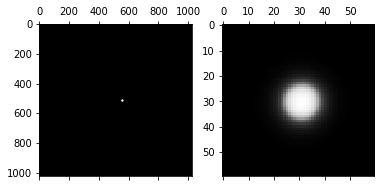

In [4]:
# Show average probe

rad = 30
xCoM_init,yCoM_init = py4DSTEM.process.utils.get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

#### From ROI

In [5]:
# Load data

fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read(fp)

/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM file, v0.2. Reading...


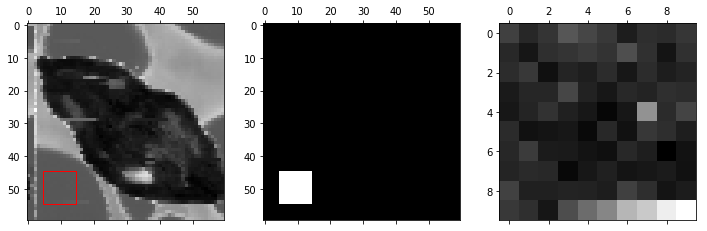

In [6]:
# Select ROI

xmin,xmax=45,55
ymin,ymax=5,15

ROI = np.zeros_like(dc.data4D[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
ave_im = np.average(dc.data4D,axis=(2,3))
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(ave_im,cmap='gray')
ax1.add_patch(roi_rect)
ax2.matshow(ROI,cmap='gray')
ax3.matshow(ave_im[ROI].reshape(xmax-xmin,ymax-ymin),cmap='gray')
plt.show()

In [7]:
# Get probe

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3
verbose = False

probe = get_average_probe_from_ROI(dc, ROI=ROI,
                                       mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

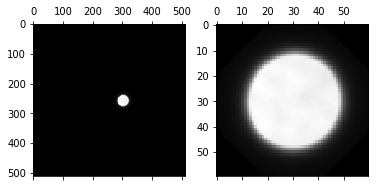

In [8]:
# Show average probe

rad = 30
xCoM_init,yCoM_init = py4DSTEM.process.utils.get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

#### Synthetic Probe

Note that the function here simply generates a synthetic probe; parameter determination is demonstrated later in this notebook.

In [9]:
radius = 18
width = 4

probe = get_synthetic_probe(Q_Nx=512, Q_Ny=512, radius=radius, width=width)

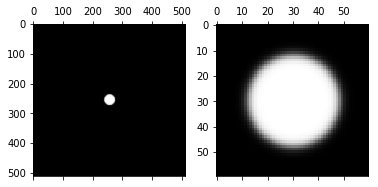

In [10]:
# Show average probe

rad = 30
xCoM_init,yCoM_init = py4DSTEM.process.utils.get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

### Create vacuum probe kernel

The following approaches are demoed below:
1. Simple kernel (normed to integrate to one, nothing subtracted)
2. Subtract gaussian (normed to integrate to zero, gaussian subtracted)
3. Subtract annulus (normed to integrate to zero, annular trench subtracted)

#### Simple kernel

In [11]:
probe_kernel = get_probe_kernel(probe)

#### Subtract gaussian

In [12]:
sigma_probe_scale=4

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

#### Subtract annulus

In [13]:
radius = 12
trenchwidth = 5
blurwidth = 5

probe_kernel = get_probe_kernel_logistictrench(probe, radius=radius,
                                                      trenchwidth=trenchwidth,
                                                      blurwidth=blurwidth)

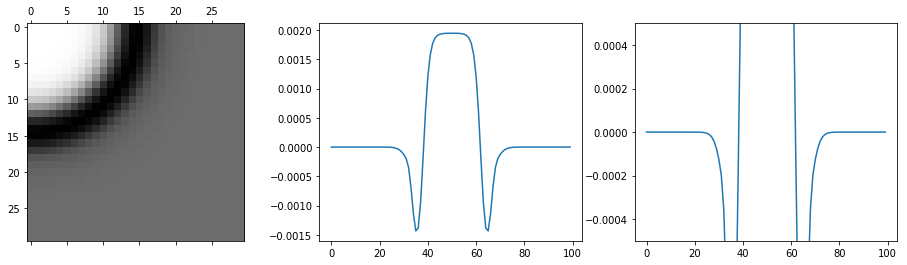

In [14]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length=50
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.matshow(probe_kernel[:rad,:rad])
ax2.plot(np.arange(len(line_profile)),line_profile)
ax3.plot(np.arange(len(line_profile)),line_profile)
ax3.set_ylim(-0.0005,0.0005)
plt.show()

### Synthetic probes: parameter determination

Under construction!

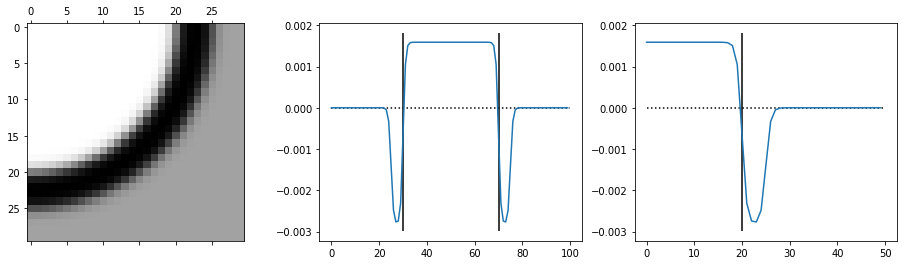

In [40]:
radius = 20
width = 2
trenchwidth = 5

probe = get_synthetic_probe(Q_Nx=512, Q_Ny=512, radius=radius, width=width)
probe_kernel = get_probe_kernel_logistictrench(probe, radius=radius,
                                                      trenchwidth=trenchwidth,
                                                      blurwidth=width)


# Display probe_kernel, with line profile

rad=30
lineprofile_length=50
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(512,512))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.matshow(probe_kernel[:rad,:rad])
ax2.plot(np.arange(len(line_profile)),line_profile)
ax2.hlines(0,0,2*lineprofile_length,linestyles=':')
ax2.vlines((lineprofile_length-radius,lineprofile_length+radius),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyles='-')
ax3.plot(np.arange(len(line_profile_right)),line_profile_right)
ax3.hlines(0,0,lineprofile_length,linestyles=':')
ax3.vlines(radius,ax3.get_ylim()[0],ax3.get_ylim()[1],linestyles='-')
plt.show()

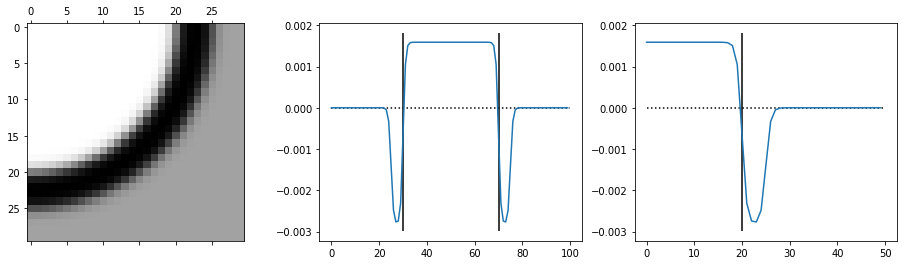

Value at rad = -0.0006480232716930831


In [38]:
radius = 20
width = 2
trenchwidth = 5

probe = get_synthetic_probe(Q_Nx=512, Q_Ny=512, radius=radius, width=width)
probe_kernel = get_probe_kernel_logistictrench(probe, radius=radius,
                                                      trenchwidth=trenchwidth,
                                                      blurwidth=width)


# Display probe_kernel, with line profile

rad=30
lineprofile_length=50
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(512,512))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.matshow(probe_kernel[:rad,:rad])
ax2.plot(np.arange(len(line_profile)),line_profile)
ax2.hlines(0,0,2*lineprofile_length,linestyles=':')
ax2.vlines((lineprofile_length-radius,lineprofile_length+radius),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyles='-')
ax3.plot(np.arange(len(line_profile_right)),line_profile_right)
ax3.hlines(0,0,lineprofile_length,linestyles=':')
ax3.vlines(radius,ax3.get_ylim()[0],ax3.get_ylim()[1],linestyles='-')
plt.show()


val = py4DSTEM.process.utils.linear_interpolation_1D(line_profile_right,radius)
print("Value at rad = {}".format(val))

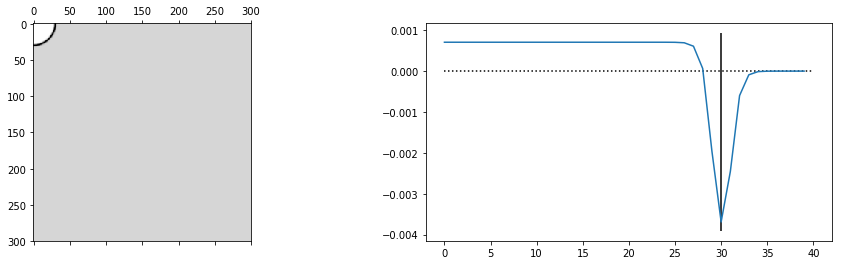

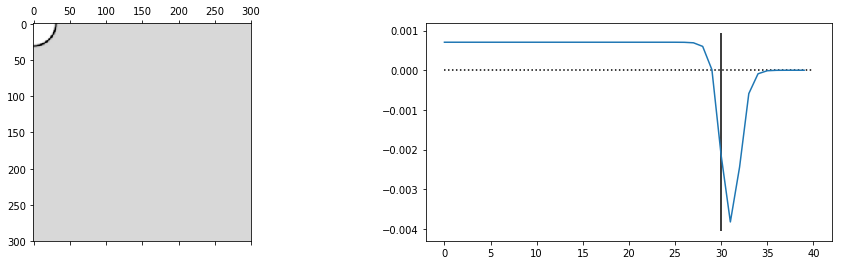

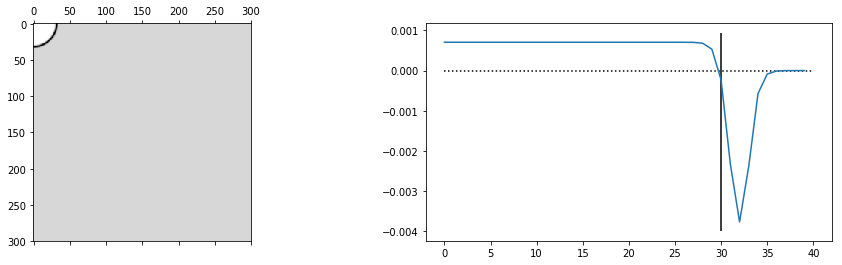

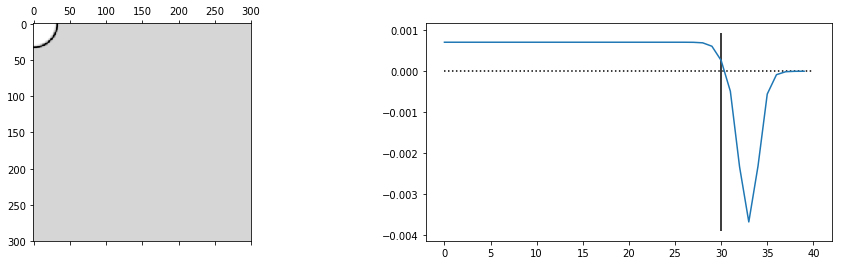

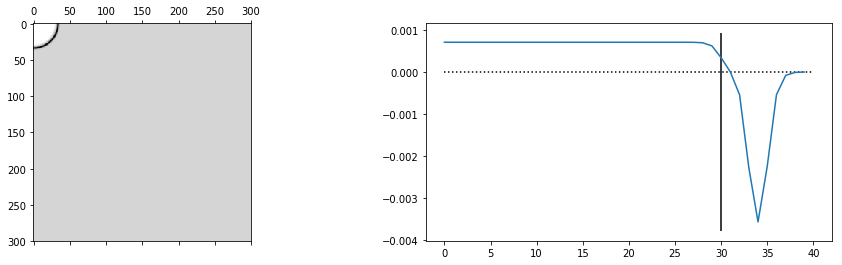

[-0.00368974 -0.00214411 -0.00023876  0.00026387  0.00033886]


In [126]:
# Get a synthetic probe kernel

radius = 30
width = 2
trenchwidth = 2

kernel_radii = radius + np.arange(-1,4)
scores = np.zeros_like(kernel_radii,dtype=float)

probe = get_synthetic_probe(Q_Nx=512, Q_Ny=512, radius=radius, width=width)
for i in range(len(kernel_radii)):
    probe_kernel = get_probe_kernel_logistictrench(probe, radius=kernel_radii[i],
                                                          trenchwidth=trenchwidth,
                                                          blurwidth=width)
    
    line_profile = np.sum(probe_kernel[:int(probe_kernel.shape[0]/2),:2],axis=(1))
    scores[i] = py4DSTEM.process.utils.linear_interpolation_1D(line_profile,radius)
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
    ax1.matshow(probe_kernel[:300,:300])
    ax2.plot(np.arange(int(radius+10)),line_profile[:int(radius+10)])
    ax2.hlines(0,0,int(radius+10),linestyles=':')
    ax2.vlines(radius,ax2.get_ylim()[0],ax2.get_ylim()[1],linestyles='-')
    plt.show()

print(scores)
kernel_radius = kernel_radii[np.argmin(np.abs(scores))]

In [120]:
np.argmin(np.abs(scores))

3

In [121]:
kernel_radius

202

In [56]:
def interpolate_val(ar,x):
    x0,x1 = int(np.floor(x)),int(np.ceil(x))
    if x0==x1:
        return ar[x0]
    else:
        dx = x-x0
        return (1-dx)*ar[x0] + dx*ar[x1]

In [ ]:
py4DSTEM.process.utils.linear_interpolation_1D(ar,6)

#### Convolution kernels from probes - a few technical points

All of the kernels are normalized such that the total cross correlation signal of a given Bragg peak will roughly reflect the totaly signal in that peak in the data. For each kernel the center of the probe is shifted to the corners of the array in order to remove phase ramps that would otherwise appear in Fourier space during calculation of the cross correlation.

In the latter two kernels above, a function is subracted from the normalized probe template, such that the entire kernel sums to zero.  This is helpful because the cross correlation of regions dominated by noise will then tend to zero.  Kernel 2 subtracts off a gaussian, and kernel 3 subtracts off an annular well (given by a pair of logistic functions).  The former approach has the advantage of minimizing parameters, the latter approach has the advantage of leaving the interior of the probe unaltered while also keeping the negative tails of the kernel tight about the probe.